In [70]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [71]:
# parameters
k = 1000
train = True
strategy_name = "etfstsm_moskowitz_all"
delete_files = [".DS_Store", "del_dirs.sh", "inti.py"]
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))
dirs = [d for d in dirs if d not in delete_files]

print(dirs)

['MaxDD_means_0.05_10', 'MaxDD_means_0.05_100', 'MaxDD_means_0.15_10', 'MaxDD_means_0.15_100', 'MaxDD_means_0.1_10', 'MaxDD_means_0.1_100', 'MaxDD_means_0.25_10', 'MaxDD_means_0.25_100', 'MaxDD_means_0.2_10', 'MaxDD_means_0.2_100', 'MaxDD_means_0.35_10', 'MaxDD_means_0.35_100', 'MaxDD_means_0.3_10', 'MaxDD_means_0.3_100', 'MaxDD_means_0.45_10', 'MaxDD_means_0.45_100', 'MaxDD_means_0.4_10', 'MaxDD_means_0.4_100', 'MaxDD_means_0.55_10', 'MaxDD_means_0.55_100', 'MaxDD_means_0.5_10', 'MaxDD_means_0.5_100', 'MaxDD_means_0.65_10', 'MaxDD_means_0.65_100', 'MaxDD_means_0.6_10', 'MaxDD_means_0.6_100', 'MaxDD_means_0.75_10', 'MaxDD_means_0.75_100', 'MaxDD_means_0.7_10', 'MaxDD_means_0.7_100', 'MaxDD_means_0.85_10', 'MaxDD_means_0.85_100', 'MaxDD_means_0.8_10', 'MaxDD_means_0.8_100', 'MaxDD_means_0.95_10', 'MaxDD_means_0.95_100', 'MaxDD_means_0.9_10', 'MaxDD_means_0.9_100', 'MaxDD_means_1_10', 'MaxDD_means_1_100', 'Sharpe_means_0.05_10', 'Sharpe_means_0.05_100', 'Sharpe_means_0.05_1000', 'Sharpe_

In [72]:
plot = False
windows = range(30, 377 + 1, 1)

all_results = []
for dir in dirs:

    utility = dir.split("_")[0]

    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    if plot:
        print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    # robust_utility_train = chosen_utility_vector_train.mean()

    # find position of scores that match final_utility
    position = functionals.find_utility_position(utilities=optmization_train["utilities"], utility_value=chosen_utility_vector_train)

    # find window that matches position
    robust_parameter = windows[position]

    # portfolio results
    robust_utility_train = diag.compute_metric(portoflio_returns=portfolio_train['agg_scaled_portfolio_returns'], metric_name=utility)
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    round_digits = 2 if utility != '% Positive Ret.' else 4
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Robust Parameter": robust_parameter,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), round_digits),
        "Train Utility Std": np.round(utilities_val_train.std().item(), round_digits),
        "Robust Train Utility": np.round(robust_utility_train, round_digits),
        "Robust Test Utility": np.round(robust_utility_test, round_digits),
        "Generalization Gap": np.round(robust_utility_test - robust_utility_train, round_digits).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])

    if plot:
        ax = sns.histplot(data=utility_val_df, palette="deep")

        plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
        plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
        plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
        plt.legend(fontsize=8)
        plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

        plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

In [73]:
all_results_df.sort_values(by=["Bsize", "Alpha"])

,Utility,Functional,Alpha,Bsize,Robust Parameter,Train Utility Mean,Train Utility Std,Robust Train Utility,Robust Test Utility,Generalization Gap
0,MaxDD,means,0.05,10,218,-27.08,1.92,-10.94,-6.57,4.37
0,Sharpe,means,0.05,10,137,0.11,0.03,2.28,2.63,0.35
0,Sortino,means,0.05,10,137,0.15,0.04,3.26,3.50,0.24
0,MaxDD,means,0.1,10,169,-27.08,1.92,-8.99,-6.17,2.81
0,Sharpe,means,0.1,10,73,0.11,0.03,3.04,3.16,0.11
...,...,...,...,...,...,...,...,...,...,...
0,Sharpe,means,0.8,1000,307,0.16,0.04,1.36,1.59,0.23
0,Sharpe,means,0.85,1000,359,0.16,0.04,1.40,1.60,0.20
0,Sharpe,means,0.9,1000,336,0.16,0.04,1.42,1.29,-0.13
0,Sharpe,means,0.95,1000,333,0.16,0.04,1.34,1.15,-0.19


In [74]:
df_filtered = all_results_df.copy()
df_filtered.loc[df_filtered['Alpha'] == 'max', 'Alpha'] = 1.0
df_filtered['Alpha'] = pd.to_numeric(df_filtered['Alpha'])
df_filtered["Generalization Gap Abs"] = df_filtered["Generalization Gap"].abs()

utilities = df_filtered['Utility'].unique()
Bsizes = df_filtered['Bsize'].sort_values().unique()

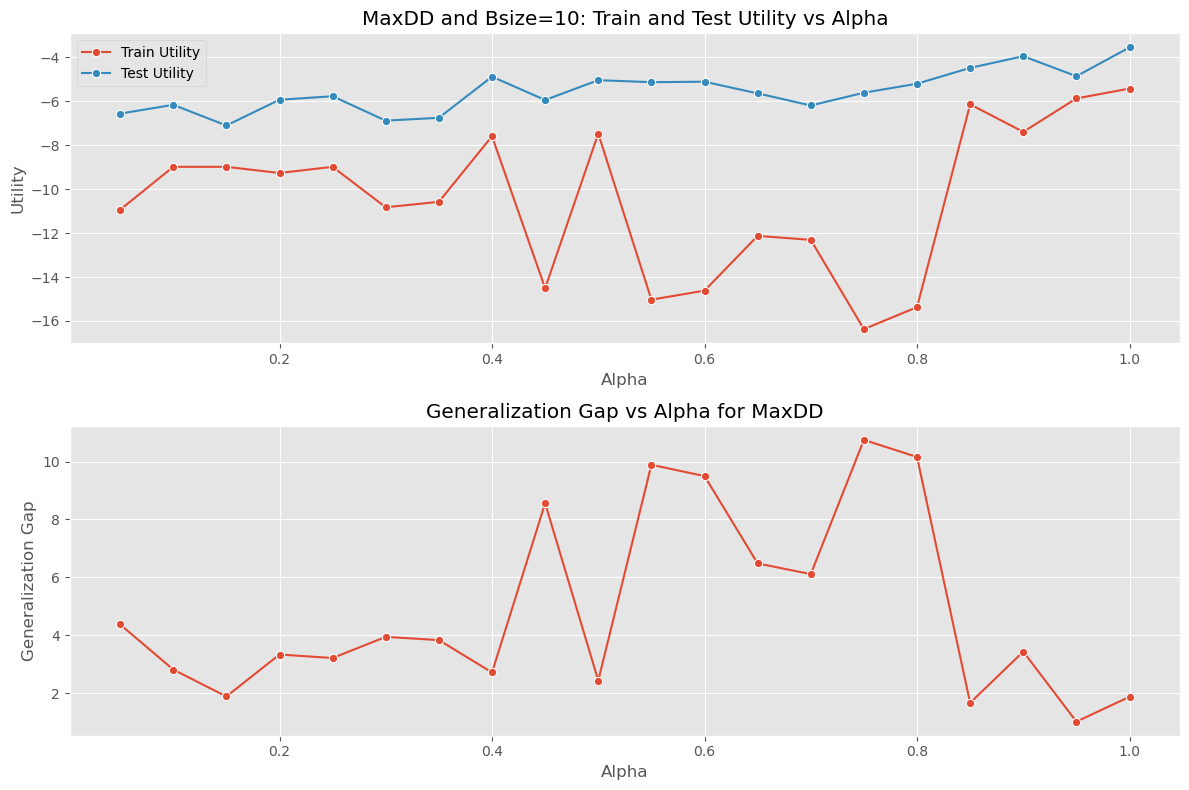

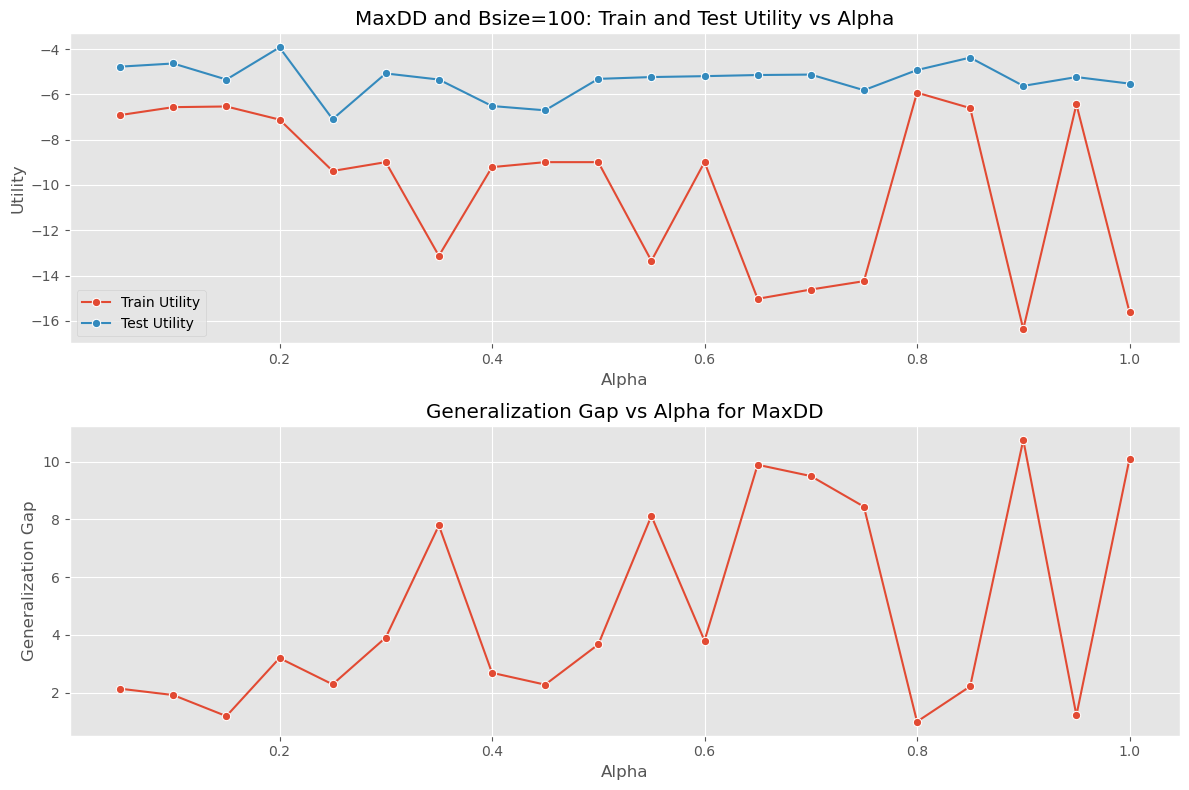

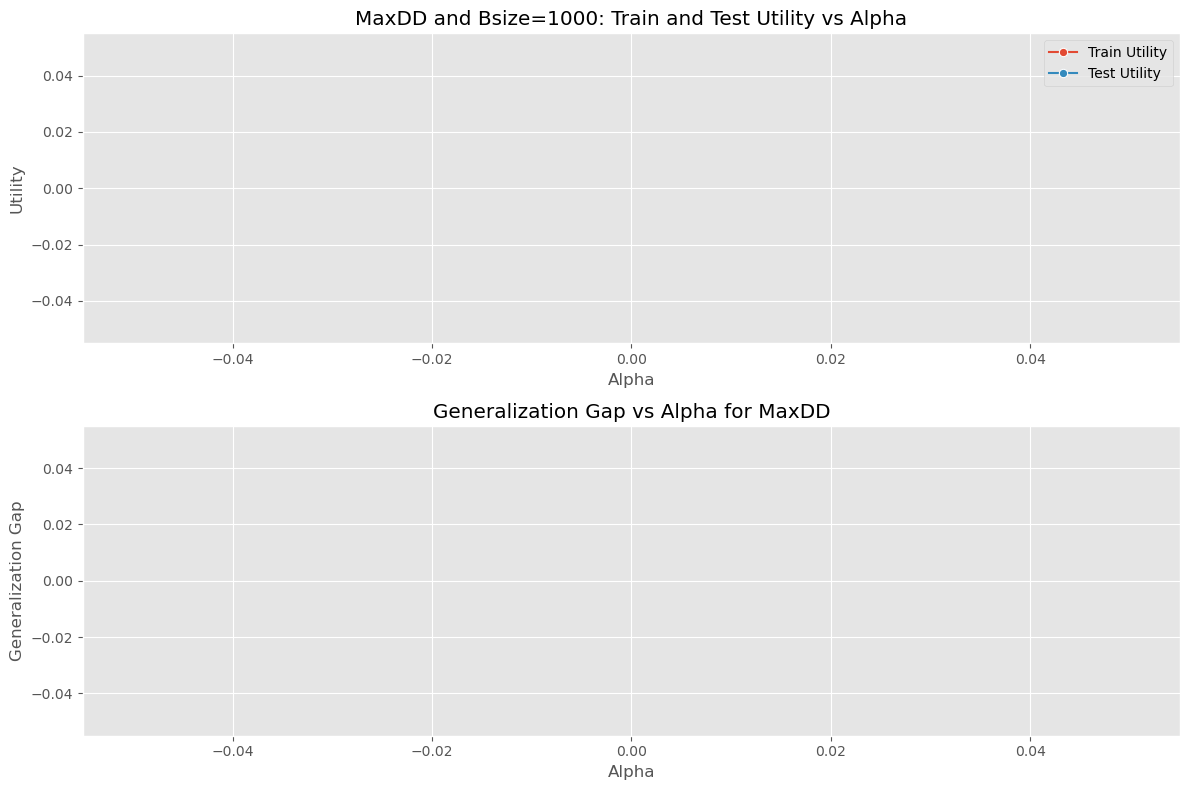

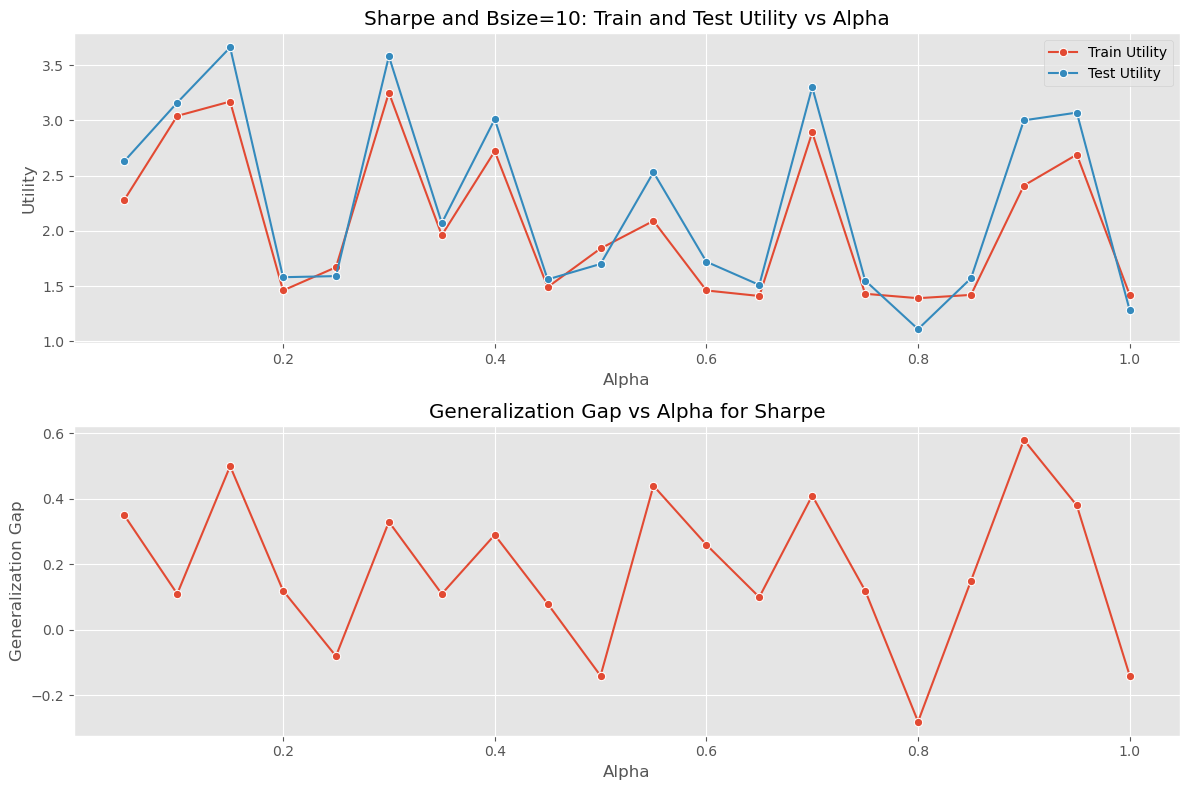

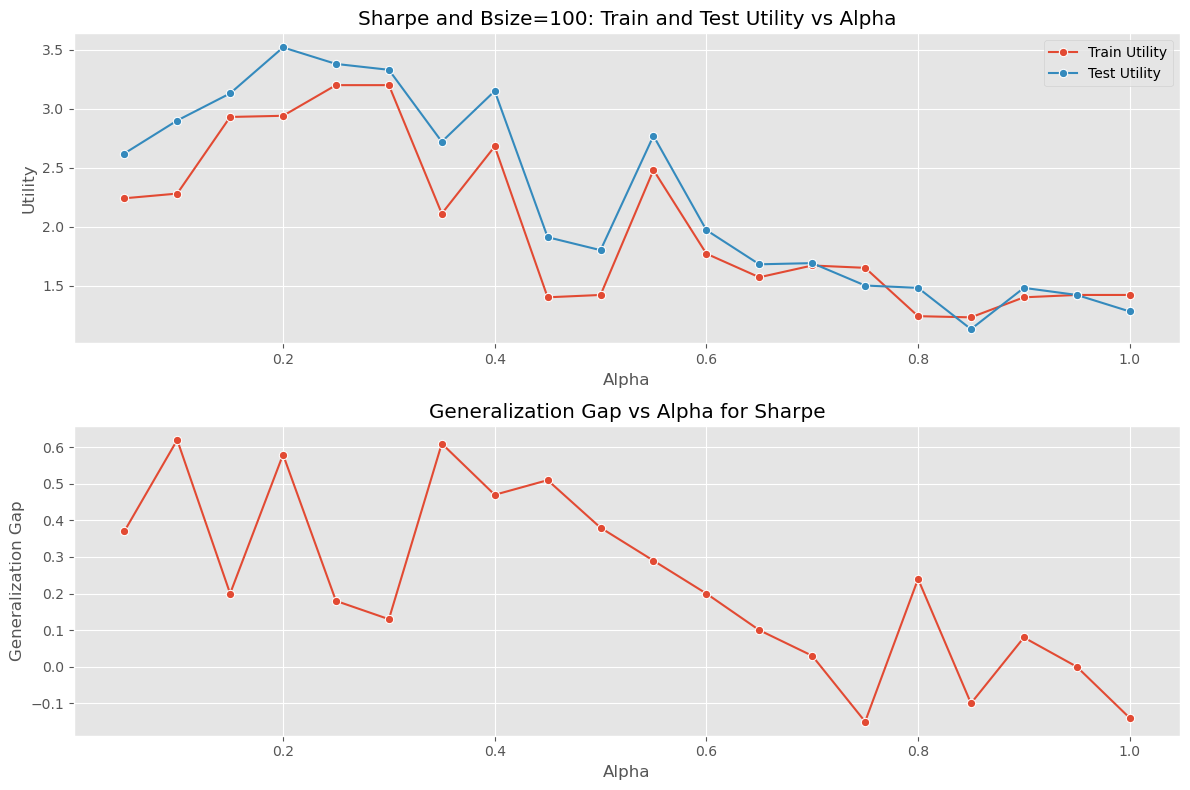

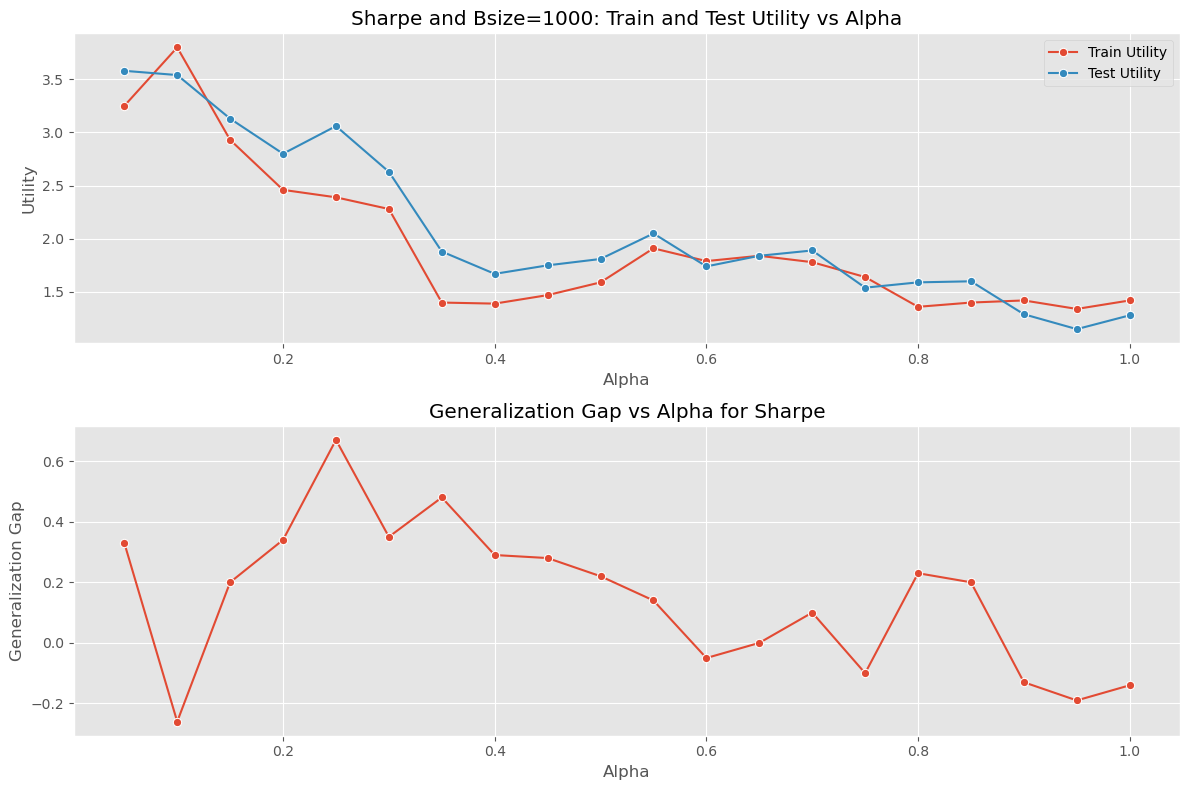

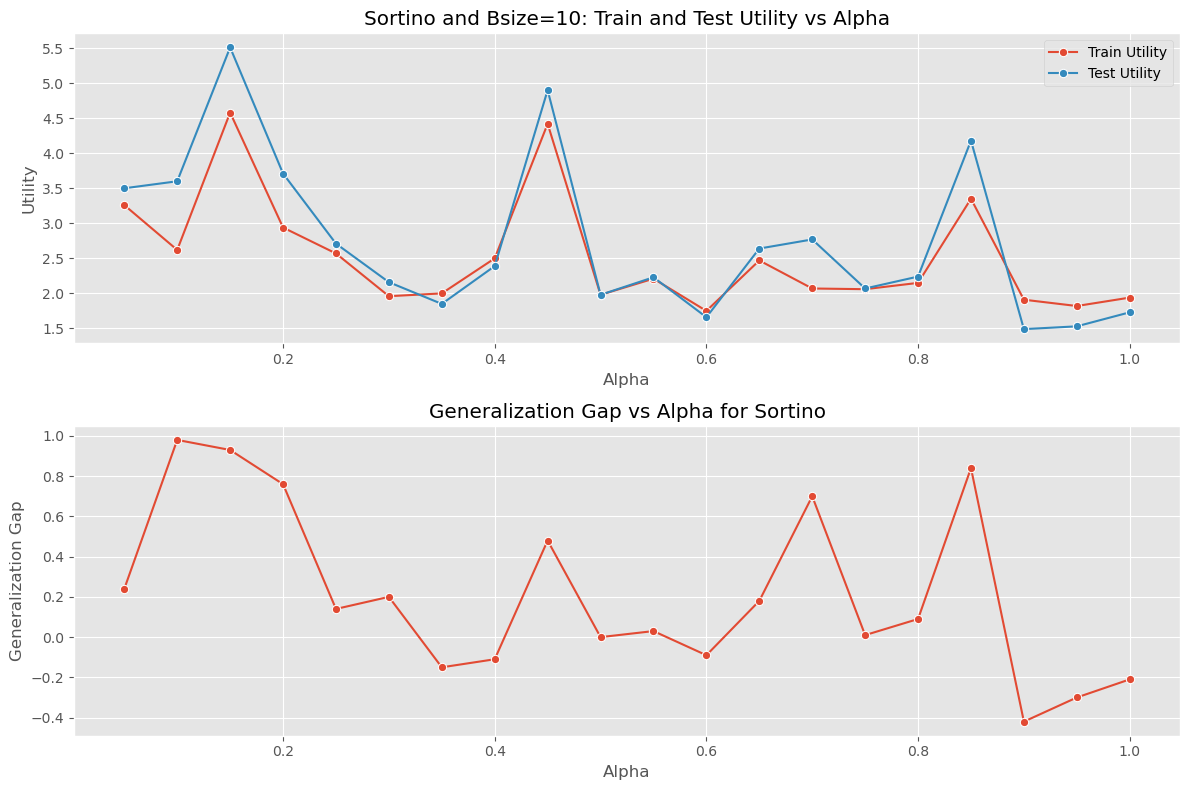

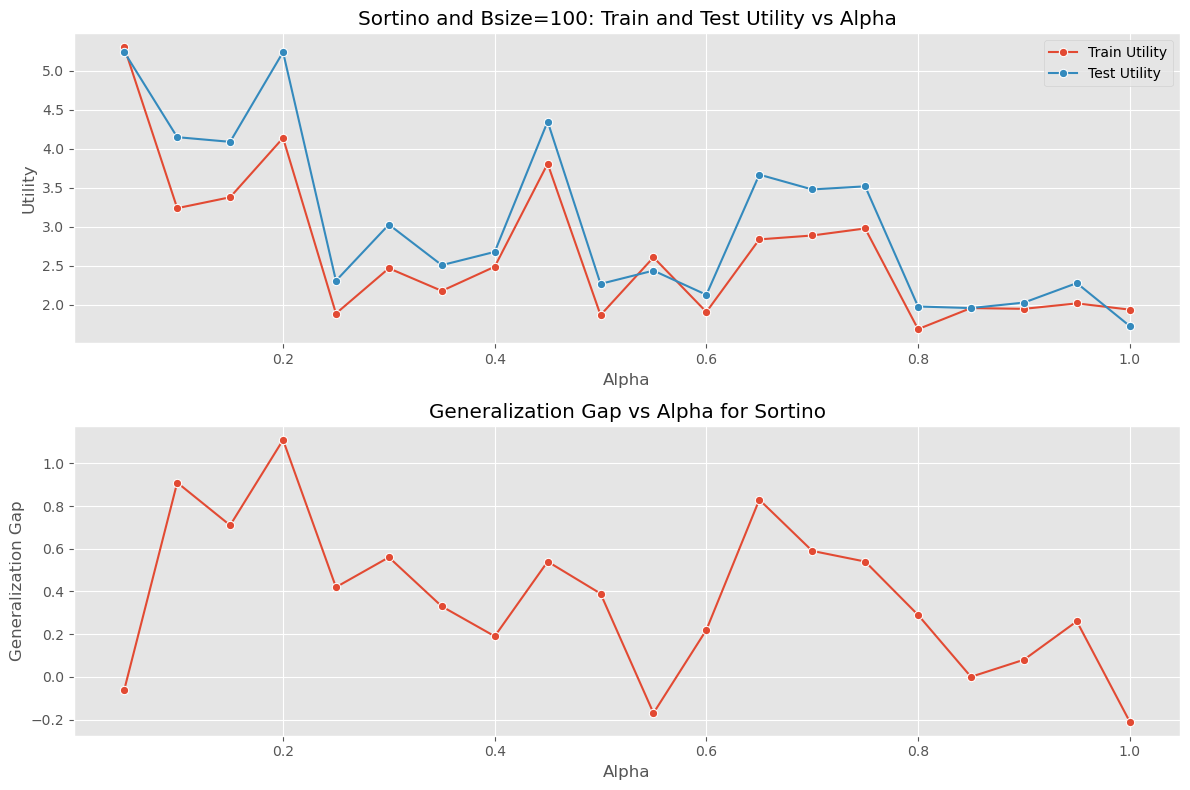

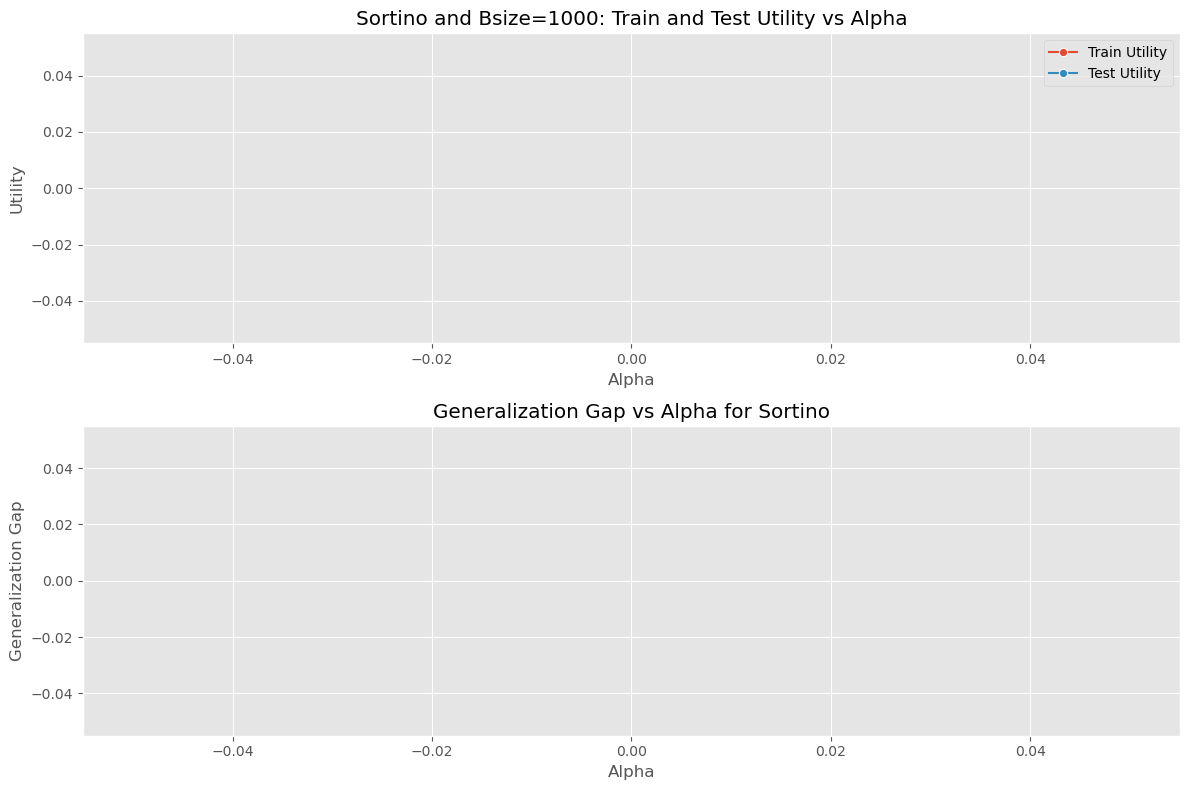

In [75]:
# Plotting
for utility in utilities:
    for Bsize in Bsizes:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

        plot_df = df_filtered[(df_filtered['Utility'] == utility) & (df_filtered['Bsize'] == Bsize)]
        
        # Subplot 1: Robust Train and Test Utility vs Alpha for each Bsize
        sns.lineplot(data=plot_df, x='Alpha', y='Robust Train Utility', ax=axes[0], marker='o', label='Train Utility')
        sns.lineplot(data=plot_df, x='Alpha', y='Robust Test Utility', ax=axes[0], marker='o', label='Test Utility')
        axes[0].set_title(f'{utility} and Bsize={Bsize}: Train and Test Utility vs Alpha')
        axes[0].set_xlabel('Alpha')
        axes[0].set_ylabel('Utility')
        
        # Subplot 2: Generalization Gap vs Alpha for each Bsize
        sns.lineplot(data=plot_df, x='Alpha', y='Generalization Gap', ax=axes[1], marker='o')
        axes[1].set_title(f'Generalization Gap vs Alpha for {utility}')
        axes[1].set_xlabel('Alpha')
        axes[1].set_ylabel('Generalization Gap')

        plt.tight_layout()
        plt.show()

In [76]:
# # Plotting
# for utility in utilities:
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # Plot: Generalization Gap vs Alpha for each Bsize
#     sns.lineplot(data=df_filtered[df_filtered['Utility'] == utility], x='Alpha', y='Generalization Gap', hue='Bsize', ax=ax, marker='o')
#     ax.set_title(f'{utility}: Generalization Gap vs Alpha')
#     ax.set_xlabel('Alpha')
#     ax.set_ylabel('Generalization Gap')

#     plt.tight_layout()
#     plt.show()

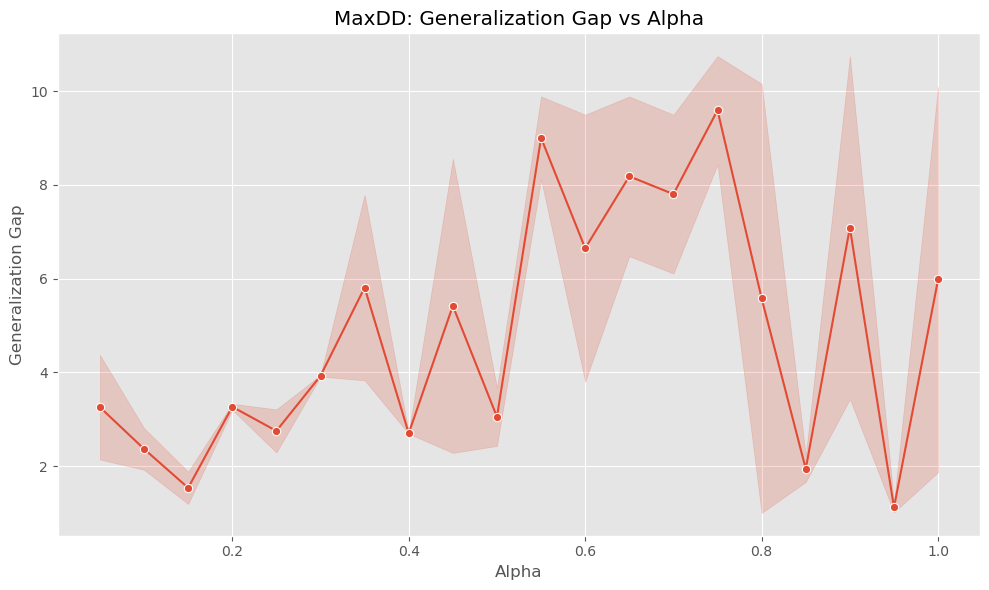

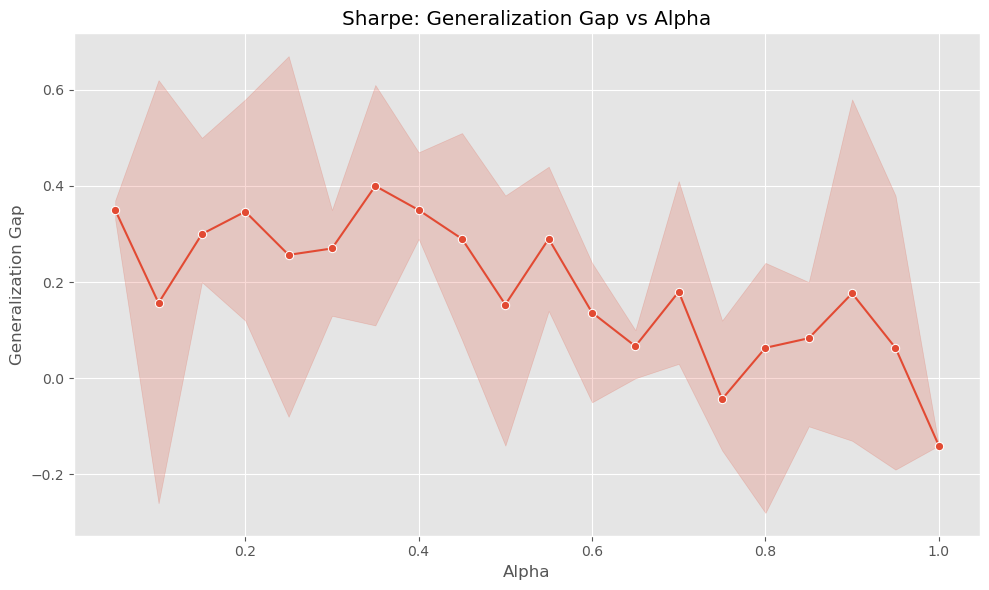

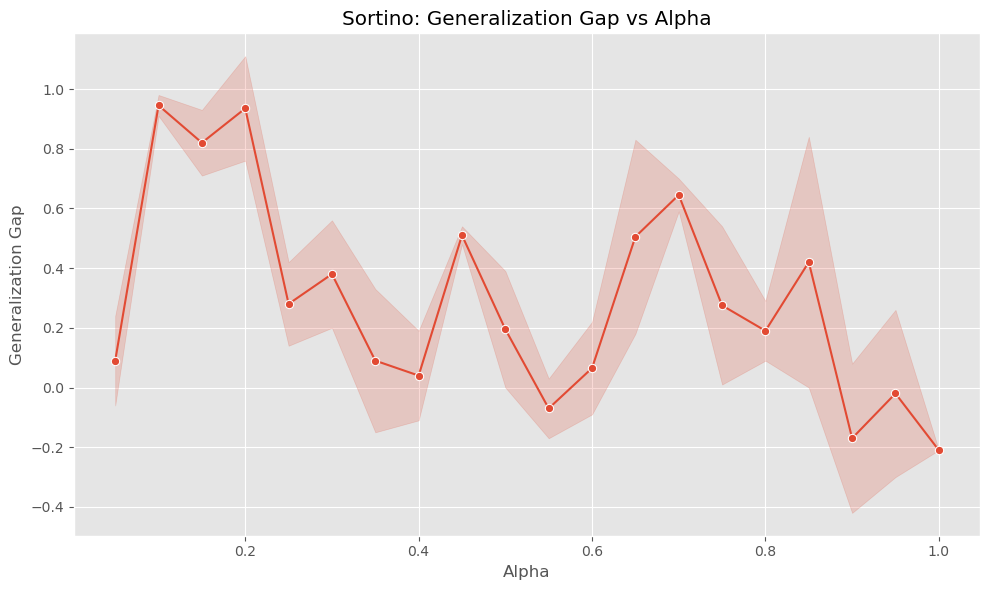

In [77]:
# Plotting
for utility in utilities:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot: Generalization Gap vs Alpha for each Bsize
    sns.lineplot(data=df_filtered[df_filtered['Utility'] == utility], x='Alpha', y='Generalization Gap', ax=ax, marker='o')
    ax.set_title(f'{utility}: Generalization Gap vs Alpha')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Generalization Gap')

    plt.tight_layout()
    plt.show()

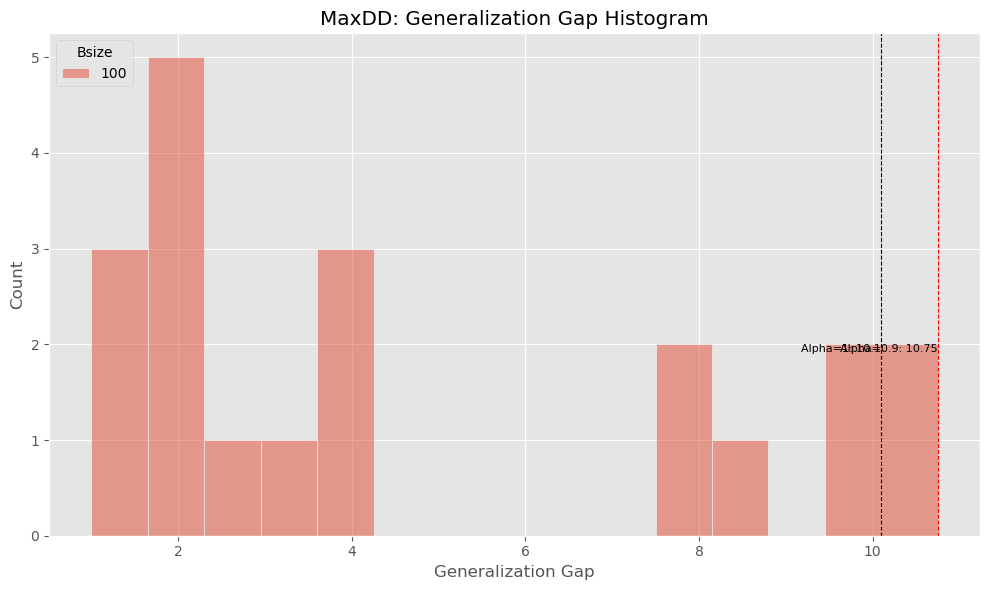

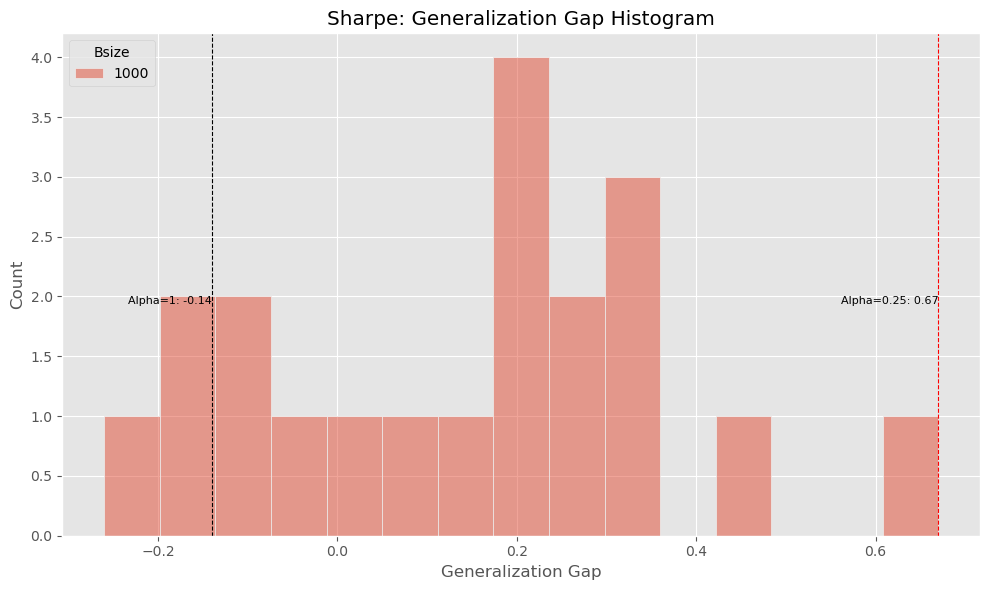

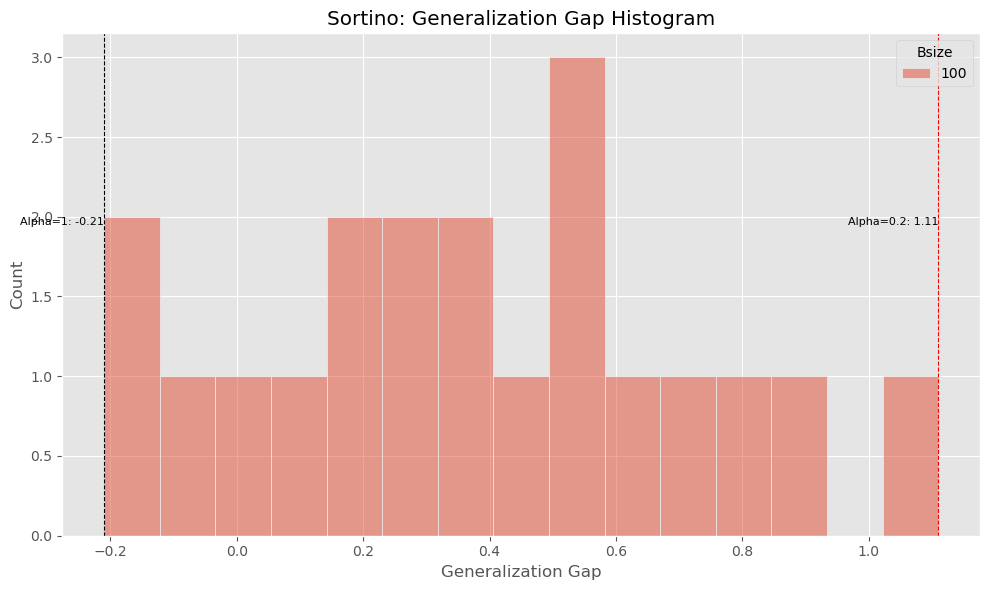

In [78]:
# Plotting
for utility in utilities:
    fig, ax = plt.subplots(figsize=(10, 6))

    hist_df = df_filtered[df_filtered['Utility'] == utility]
    max_Bsize = df_filtered[df_filtered['Utility'] == utility]["Bsize"].max()
    hist_df = hist_df[hist_df["Bsize"] == max_Bsize]
    
    # Plot: Generalization Gap vs Alpha for each Bsize
    sns.histplot(data=hist_df, x='Generalization Gap', ax=ax, hue="Bsize", bins=15)
    ax.set_title(f'{utility}: Generalization Gap Histogram')
    ax.set_xlabel('Generalization Gap')

    # add vertical dashed line for alpha=1
    alpha_1_gap = hist_df.loc[hist_df["Alpha"] == 1]["Generalization Gap"].iloc[0]
    ax.axvline(alpha_1_gap, color='black', linestyle='--', label='Alpha=1', linewidth=0.8)
    ax.text(alpha_1_gap, 2, f'Alpha=1: {alpha_1_gap}', fontsize=8, ha='right', va='top')

    # add vertical dashed the alpha associated with the max generalization gap
    max_generalization_gap = hist_df["Generalization Gap"].max()
    alpha_max_gap = hist_df.loc[hist_df["Generalization Gap"] == max_generalization_gap]["Alpha"].iloc[0]
    ax.axvline(max_generalization_gap, color='red', linestyle='--', label='Alpha=1', linewidth=0.8)
    ax.text(max_generalization_gap, 2, f'Alpha={alpha_max_gap}: {max_generalization_gap}', fontsize=8, ha='right', va='top')

    plt.tight_layout()
    plt.show()